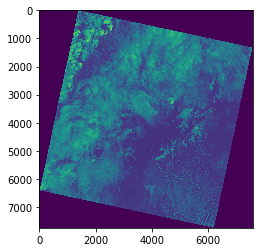

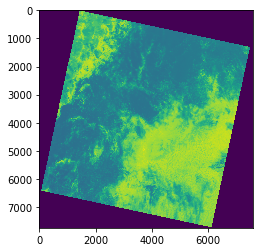

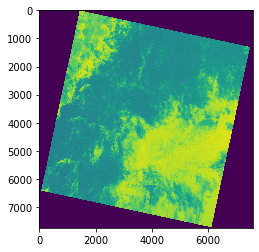

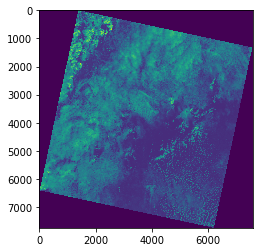

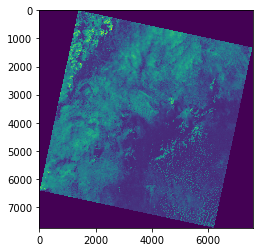

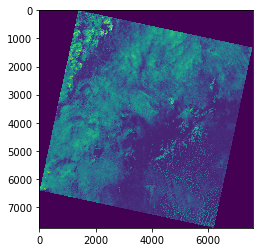

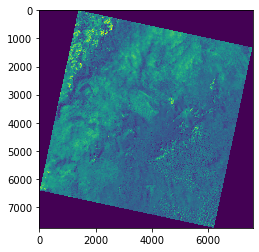

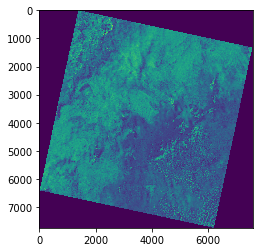

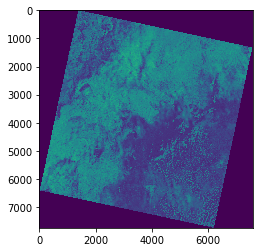

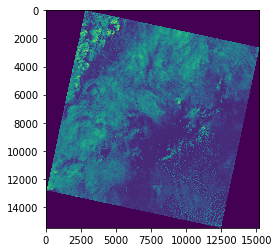

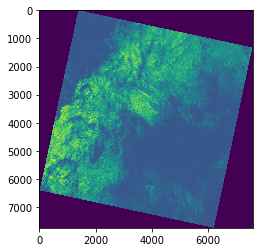

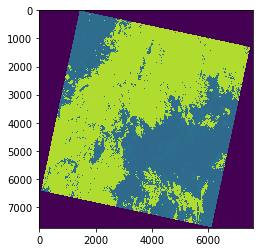

In [21]:
%matplotlib inline
from PIL import Image
import numpy
import xarray as xr
import rasterio
from rasterio.plot import show
import os

img_folder_list = os.listdir("./data/")
for img_folder in img_folder_list:
    img_list = os.listdir("./data/"+img_folder+"/")
    for img in img_list:
        sat_img = xr.open_rasterio("./data/"+img_folder+"/"+img)
        xr_img_dataset = da.to_dataset(name="img_table1")
        show(sat_img)

## Limpieza de datos

Para optimizar el entrenamiento y el testeo de los datos se cambia el valor de todo pixel con nubes a 9999. De esta forma, el pixel es excluido del entrenamiento y el testeo de los modelos. Esto permite reducir la cantidad de datos a solo las characteristicas del suelo y el agua. Se realiza este filtrado utilizando el mapa de nubes ofrecido por USGS presente en la banda 

In [11]:
"""
This algorithms was developed by Salomón Rarmiréz at Institute of Hydrology, 
Meteorology and Environmental Studies (IDEAM), Bogotá, Colombia)
Reference
https://raw.githubusercontent.com/OpenDatacubeIDEAM/cdcol/desacoplado/algorithms/medianas/medianas_2.1.py
"""

import xarray as xr
import numpy as np

#La funcion isin permite verificar si el elemento (elemento) que se pasa por parametro está dentro del arreglo (test_elements)
#Esta funcion se define para verificar los valores validos de la mascara de nube (pixel_qa) 
def isin(element, test_elements, assume_unique=False, invert=False):
    "definiendo la función isin de numpy para la versión anterior a la 1.13, en la que no existe"
    element = np.asarray(element)
    return np.in1d(element, test_elements, assume_unique=assume_unique,invert=invert).reshape(element.shape)


def median_compound(xarr,product,bands,min_valid=1,normalized=False):
    nbar = xarr
    #Un valor negativo suficientemente grande para representar cuando no hay datos
    nodata=-9999
    medians={}

    #Conjunto de valores valido para la mascara de nube
    validValues=set()

    #Dependiendo del satellite, se definen unos valores distintos para la mascara
    #Estos valores se definen en la página de LandSat: https://landsat.usgs.gov/landsat-surface-reflectance-quality-assessment
    #Son valores validos porque representan agua (water) o un "pixel claro" (clear)
    if product=="LS7_ETM_LEDAPS" or product=="LS5_TM_LEDAPS":
        validValues=[66,68,130,132]
    elif product == "LS8_OLI_LASRC":
        validValues=[322, 386, 834, 898, 1346, 324, 388, 836, 900, 1348]

    cloud_mask=isin(nbar["pixel_qa"].values, validValues)

    #Se hace un recorrido sobre las bandas
    for band in bands:
        # np.where es la funcion where de la libreria numpy que retorna un arreglo o un set de arreglos con datos que cumplen con la condicion dada por parametro
        # 
        datos=np.where(np.logical_and(nbar.data_vars[band]!=nodata,cloud_mask),nbar.data_vars[band], np.nan)
        #np.isnan verifica que valores no son numero o no estan definidos. En este caso, se usa ~ para invertir los valores y saber que valores de datos si estan definidos
        allNan=~np.isnan(datos)
        if normalized:
            #Calcula la mediana arimetica sobre el arreglo de datos  ,sobre el eje  , ignorando los valores NaN
            m=np.nanmean(datos.reshape((datos.shape[0],-1)), axis=1)
            #Calcula la desviacion estandar sobre el arreglo de datos  , sobre el eje , ignorando los valores NaN
            st=np.nanstd(datos.reshape((datos.shape[0],-1)), axis=1)
            datos=np.true_divide((datos-m[:,np.newaxis,np.newaxis]), st[:,np.newaxis,np.newaxis])*np.nanmean(st)+np.nanmean(m)
        #Calcula la mediana aritmetica 
        medians[band]=np.nanmedian(datos,0)
        medians[band][np.sum(allNan,0)<min_valid]=np.nan
    #Elimina la variable datos y la asociacion que tiene en el algoritmo
    del datos


    ncoords=[]
    xdims =[]
    xcords={}
    for x in nbar.coords:
        if(x!='time'):
            ncoords.append( ( x, nbar.coords[x]) )
            xdims.append(x)
            xcords[x]=nbar.coords[x]
    variables ={k: xr.DataArray(v, dims=xdims,coords=ncoords)
                 for k, v in medians.items()}
    #Genera el dataset (netcdf) con las bandas con el sistema de referencia de coordenadas
    output=xr.Dataset(variables, attrs={'crs':nbar.crs})

    for x in output.coords:
        output.coords[x].attrs["units"]=nbar.coords[x].units


    return output

<xarray.Dataset>
Dimensions:     (band: 1, x: 7591, y: 7741)
Coordinates:
  * band        (band) int32 1
  * y           (y) float64 2.757e+05 2.757e+05 2.756e+05 ... 4.353e+04 4.35e+04
  * x           (x) float64 2.046e+05 2.046e+05 ... 4.323e+05 4.323e+05
Data variables:
    img_table1  (band, y, x) uint16 ...